<a href="https://colab.research.google.com/github/abdala-Mohamed/ecg_classification/blob/master/graduation_ecg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##import

In [1]:
import numpy as np
import scipy.io
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import os
from keras import backend as K
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import Add 
from keras.layers import MaxPooling1D
from keras.layers.core import Lambda
from keras.layers.core import Dense, Activation
from keras.layers.wrappers import TimeDistributed
from keras.models import Model
from keras.layers import Input
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from numpy import array
from sklearn.model_selection import train_test_split
from random import shuffle
from sklearn.utils import shuffle

Using TensorFlow backend.


##Download

In [0]:
!wget https://physionet.org/files/challenge-2017/1.0.0/training2017.zip?download
!wget https://physionet.org/files/challenge-2017/1.0.0/training/RECORDS-af?download
!wget https://physionet.org/content/challenge-2017/1.0.0/training/RECORDS-noisy
!wget https://physionet.org/content/challenge-2017/1.0.0/training/RECORDS-normal
!wget https://physionet.org/content/challenge-2017/1.0.0/training/RECORDS-other
!unzip /content/training2017.zip?download

##Data_preperation

In [0]:
f = open("/content/RECORDS-af?download", "r")
Records_af = f.read().split("\n")#spilt by '/' and choose the 2nd word to get the name
f = open("/content/RECORDS-noisy", "r")
Records_noisy = f.read().split("\n")
f = open("/content/RECORDS-normal", "r")
Records_normal = f.read().split("\n")
f = open("/content/RECORDS-other", "r")
Records_other = f.read().split("\n")

normal

[-127 -162 -197 ...  -18  -22  -21]


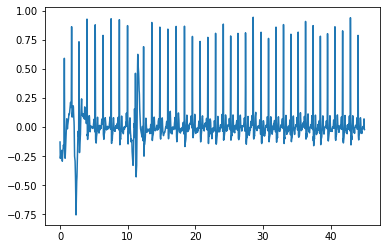

In [3]:
mat = scipy.io.loadmat('/content/training2017/A00001.mat')
data = np.array(mat['val']).squeeze()
plt.plot(np.linspace(0,len(data)/200,num = len(data)),data/1000)
print(data)

af_rythm

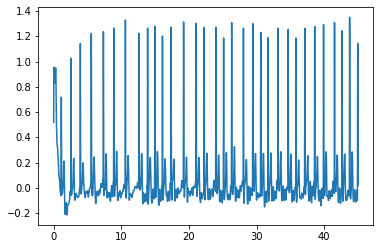

In [4]:
mat = scipy.io.loadmat('/content/training2017/A00004.mat')
data = np.array(mat['val']).squeeze()
plt.plot(np.linspace(0,len(data)/200,num = len(data)),data/1000)

other

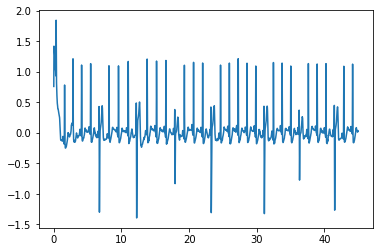

In [5]:
mat = scipy.io.loadmat('/content/training2017/A00077.mat')
data = np.array(mat['val']).squeeze()
plt.plot(np.linspace(0,len(data)/200,num = len(data)),data/1000)

noise

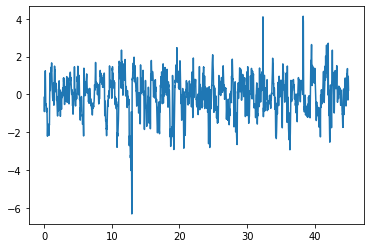

In [6]:
mat = scipy.io.loadmat('/content/training2017/A01246.mat')
data = np.array(mat['val']).squeeze()
plt.plot(np.linspace(0,len(data)/200,num = len(data)),data/1000)

train_set

In [0]:
def look_for_file(file,Records_af,Records_normal,Records_other,Records_noisy):
  for subject in Records_af:
    if (subject.split("/") == False) or (len(subject.split("/"))==1) :
      continue
    cla_ss = subject.split("/")[1]
    if '<' in (cla_ss):
      cla_ss = cla_ss.split("<")[0]
    if file == cla_ss:
      return 1
  for subject in Records_normal:
    if (subject.split("/") == False) or (len(subject.split("/"))==1):
      continue
    cla_ss = subject.split("/")[1]
    if '<' in (cla_ss):
      cla_ss = cla_ss.split("<")[0]
    if file == cla_ss:
      return 2
  for subject in Records_other:
    if (subject.split("/") == False) or (len(subject.split("/"))==1):
      continue
    cla_ss = subject.split("/")[1]
    if '<' in (cla_ss):
      cla_ss = cla_ss.split("<")[0]
    if file == cla_ss:
      return 3
  for subject in Records_noisy:
    if (subject.split("/") == False) or (len(subject.split("/"))==1):
      continue
    cla_ss = subject.split("/")[1]
    if '<' in (cla_ss):
      cla_ss = cla_ss.split("<")[0]
    if file == cla_ss:
      return 4
  print()
  return 0

In [0]:
#Records_af = 1
#Records_normal = 2
#Records_other = 3
#Records_noisy = 4
dir = "/content/training2017"
train_dataset = []
file_order = []
class_dataset = np.zeros((1,8528))
for i in range(0,8528):
  train_dataset.append([])
i = 0
for file in os.listdir( dir ):
  #print(i)
  if file.endswith( ".mat" ):
    mat = scipy.io.loadmat('/content/training2017/'+file)    
    type = look_for_file(file.split(".")[0],Records_af,Records_normal,Records_other,Records_noisy)
    if type == 0:
      print(file)
      print("stop excution")
      break
    class_dataset[0][i] = type
    train_data = np.array(mat['val']).squeeze()
    for j in train_data:
      train_dataset[i].append(j)
    i+=1

extra step

In [0]:
# def fix_train_dataset(train_dataset,class_dataset):
#   zero_dataset = np.zeros((1,256))
#   new_class_dataset = []
#   new_train_dataset = zero_dataset
#   l=0
#   k=0
#   for i in range(0,3000):
#     if i%500 == 0:
#       print(i)
#     k=0
#     for j in range(0,len(train_dataset[i])):
#       new_train_dataset[l][k] = train_dataset[i][j]
#       k+=1
#       if k == 256:
#         k=0
#         new_class_dataset.append(class_dataset[0][i])
#         l+=1
#         new_train_dataset = np.vstack([new_train_dataset, zero_dataset])

#   #remove row
#   print(np.shape(new_train_dataset))
#   print(np.shape(new_class_dataset))
#   return new_train_dataset,new_class_dataset

In [10]:
print(np.shape(train_dataset))

(8528,)


In [0]:
X = np.zeros((8528,18286))
for i in range(0,8528):
  j=0
  for k in train_dataset[i]:
    X[i][j] = k
    j+=1

##Model

#model written-1

In [0]:
"conv_subsample_lengths": [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2],
    "conv_filter_length": 16,
    "conv_num_filters_start": 32,
    "conv_init": "he_normal",
    "conv_activation": "relu",
    "conv_dropout": 0.2,
    "conv_num_skip": 2,
    "conv_increase_channels_at": 4,

    "learning_rate": 0.001,
    "batch_size": 32,
    "input_shape": [None, 1],
     "num_categories": 4

In [0]:
def _bn_relu(layer, dropout=0):
    layer = BatchNormalization()(layer)
    layer = Activation("relu")(layer)
    if dropout > 0:
      layer = Dropout(0.2)(layer)
    return layer

In [0]:
def add_conv_weight(layer,filter_length,num_filters,subsample_length=1):
    layer = Conv1D(filters=num_filters,kernel_size=filter_length,strides=subsample_length,padding='same',kernel_initializer="he_normal")(layer)
    return layer

In [0]:
def add_conv_layers(layer):
    arr = [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2]
    for subsample_length in arr:
      layer = add_conv_weight(layer,16,32,subsample_length=subsample_length)
      layer = _bn_relu(layer)
    return layer

In [0]:
def resnet_block(layer,num_filters,subsample_length,block_index):

  def zeropad(x):
      y = K.zeros_like(x)
      return K.concatenate([x, y], axis=2)

  def zeropad_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 3
    shape[2] *= 2
    return tuple(shape)

  shortcut = MaxPooling1D(pool_size=subsample_length)(layer)
  zero_pad = (block_index % 4) == 0 and block_index > 0
  if zero_pad is True:
    shortcut = Lambda(zeropad, output_shape=zeropad_output_shape)(shortcut)

  for i in range(2):
    if not (block_index == 0 and i == 0):
      layer = _bn_relu(layer,dropout=0.2 if i > 0 else 0)
    layer = add_conv_weight(layer,16,num_filters,subsample_length if i == 0 else 1)
  layer = Add()([shortcut, layer])
  return layer

In [0]:
def get_num_filters_at_index(index, num_start_filters):
    return 2**int(index / 4) * num_start_filters

In [0]:
def add_resnet_layers(layer):
  layer = add_conv_weight(layer,16,32,subsample_length=1)
  layer = _bn_relu(layer)
  arr = [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2]
  for index, subsample_length in enumerate(arr):
    num_filters = get_num_filters_at_index(index, 32)
    layer = resnet_block(layer,num_filters,subsample_length,index)
  layer = _bn_relu(layer)
  return layer

In [0]:
def add_output_layer(layer):   
  layer = TimeDistributed(Dense(4))(layer)
  return Activation('softmax')(layer)

In [0]:
# def add_compile(model):
#     optimizer = Adam(lr=0.001)
#     model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [0]:
def build_network():
  inputs = Input(shape=[None, 1],dtype='float32',name='inputs')
  x=1
  if x==0:
      layer = add_conv_layers(inputs)
  else:
      layer = add_resnet_layers(inputs)

  output = add_output_layer(layer)
  model = Model(inputs=[inputs], outputs=[output])
  optimizer = Adam(lr=0.001)
  model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
  return model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, None, 1)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 32)     544         inputs[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, 32)     128         conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, 32)     0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

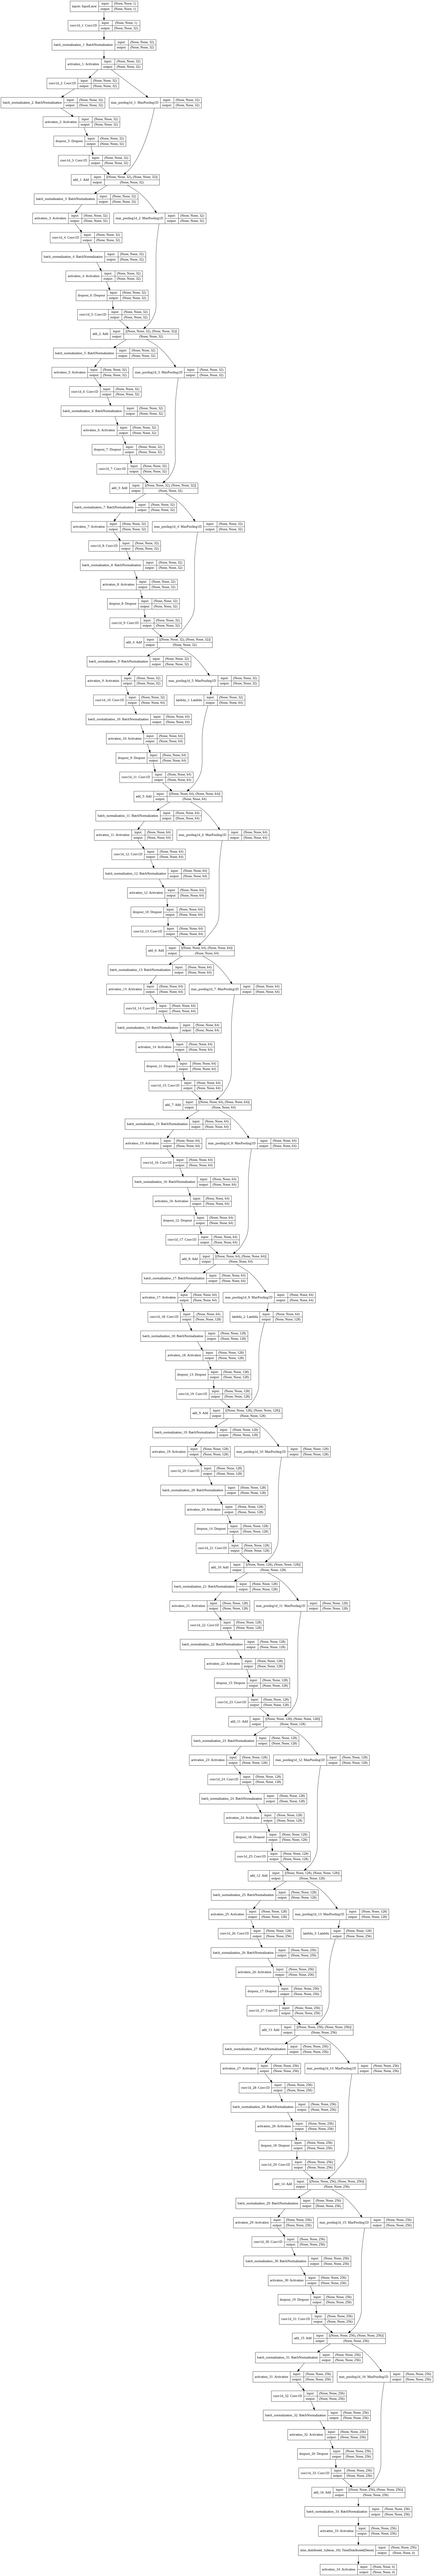

In [35]:
model = build_network()
model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

##Train

alternative model

In [21]:
model2 = Sequential()

model2.add(Dense(12000, input_dim=18286, activation='relu'))

model2.add(Dense(10000, activation='relu'))

model2.add(Dropout(0.2))

model2.add(Dense(256, activation='relu'))

model2.add(Dense(128, activation='relu'))

model2.add(Dropout(0.2))

model2.add(Dense(64, activation='relu'))

model2.add(Dense(64, activation='relu'))

model2.add(Dropout(0.2))

model2.add(Dense(32, activation='relu'))

model2.add(Dropout(0.4))

model2.add(Dense(18, activation='relu'))

model2.add(Dense(4, activation='softmax'))

optimizer = Adam(lr=0.001)

model2.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [23]:
#hot_finger transform
X,y = shuffle(X,np.transpose(class_dataset), random_state=0)
values = array(y)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = values.reshape(len(values), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded[2])
# invert first example
#inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])

X_train, X_test, y_train, y_test = train_test_split(X, onehot_encoded, test_size=0.1)
#model2.fit(X_train,y_train,epochs=10,batch_size=100)

#shit = model2.predict(X_test,batch_size=100)

[0. 1. 0. 0.]


In [25]:
model2.fit(X_train,y_train,epochs=10,batch_size=1)
shit = model2.predict(X_test,batch_size=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/10





7675/7675 [==============================] - 862s 112ms/step - loss: 11.3983 - acc: 0.2928
Epoch 2/10
4137/7675 [===============>..............] - ETA: 6:34 - loss: 11.4973 - acc: 0.2867

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-25-c3ab204b32a8>", line 1, in <module>
    model2.fit(X_train,y_train,epochs=10,batch_size=1)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/training.py", line 1178, in fit
    validation_freq=validation_freq)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/training_arrays.py", line 204, in fit_loop
    outs = fit_function(ins_batch)
  File "/usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py", line 2979, in __call__
    return self._call(inputs)
  File "/usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py", line 2937, in _call
    fetched = self._callable_fn(*array_vals)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py", line 1472, in __call__
    run_metadata_ptr)

KeyboardInterrupt: ignored